In [1]:
import os
import numpy as np
import pandas as pd
from math import sqrt
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from scipy.stats import uniform, randint
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV, GridSearchCV
import xgboost as xgb
from xgboost import plot_tree
import matplotlib.pyplot as plt

from IPython.display import display, HTML
display(HTML("<style>.container { width:55% !important; }</style>"))

# Data

In [2]:
dataset_df = pd.read_json("./data/all_ads.json")
dataset_df = dataset_df.drop(["id", "category"], axis=1)
dataset_df.head(5)

,fuel_cb,gearbox_cb,locality,manufacturer_cb,model_cb,price,tachometer,vehicle_age
0,Nafta,Automatická,Středočeský kraj,BMW,Řada 3,1349000,26000,1
1,Nafta,Manuální,Hlavní město Praha,BMW,Řada 3,455000,193107,5
2,Nafta,None,Jihočeský kraj,BMW,Řada 3,1510000,12000,1
3,Nafta,Automatická,Královéhradecký kraj,BMW,Řada 3,1228149,25400,1
4,Hybridní,Automatická,Moravskoslezský kraj,BMW,Řada 3,1703000,24000,1


In [3]:
df_skoda = dataset_df[dataset_df.manufacturer_cb == "Škoda"]
df_skoda = df_skoda.drop("manufacturer_cb", axis=1)
df_skoda.head()

,fuel_cb,gearbox_cb,locality,model_cb,price,tachometer,vehicle_age
106,Benzín,Manuální,Jihočeský kraj,Fabia,440900,0,0
107,Benzín,Manuální,Jihočeský kraj,Fabia,440900,0,0
108,Benzín,Manuální,Jihočeský kraj,Fabia,440900,0,0
109,Benzín,Manuální,Jihočeský kraj,Fabia,505600,0,0
110,Benzín,Manuální,Jihočeský kraj,Fabia,404100,0,0


In [4]:
score_df = df_skoda.copy()
onehot_columns = ['fuel_cb', 'gearbox_cb', 'locality', 'model_cb']
onehot_df = score_df[onehot_columns]
onehot_df = pd.get_dummies(onehot_df, columns=onehot_columns, prefix_sep='-')
score_onehot_drop = score_df.drop(onehot_columns, axis=1)
score_onehot = pd.concat([score_onehot_drop, onehot_df], axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(score_onehot.drop(['price'], axis=1), score_onehot.price, test_size=0.20, random_state=42)

# Model & Training

In [6]:
# params = {
#     'learning_rate': (0.1,),
#     'subsample'    : (0.2,),
#     'n_estimators' : (500,),
#     'max_depth'    : (28,),
# }

# xgb_model = GradientBoostingRegressor()
# xgb_search = RandomizedSearchCV(xgb_model, param_distributions=params, random_state=42, verbose=1, n_jobs=2, return_train_score=True)

params = {
    'max_depth': [8, 10],
    'n_estimators': [400, 500]
}
xgb_model = xgb.XGBRegressor()
xgb_search = GridSearchCV(xgb_model, params, verbose=1, n_jobs=2)

In [7]:
%%time
xgb_search.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 25 s, sys: 4.2 s, total: 29.2 s
Wall time: 1min 10s


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None, ...),
             n_jobs=2,
             param_grid={'max_depth': [8, 10], 'n_estimators': [400, 500]},
             verbose=1)

In [8]:
y_pred = xgb_search.predict(X_test)
rms = sqrt(mean_squared_error(y_test, y_pred))
print ('RMSE:', rms)

RMSE: 68495.85350728169


NotFittedError: need to call fit or load_model beforehand

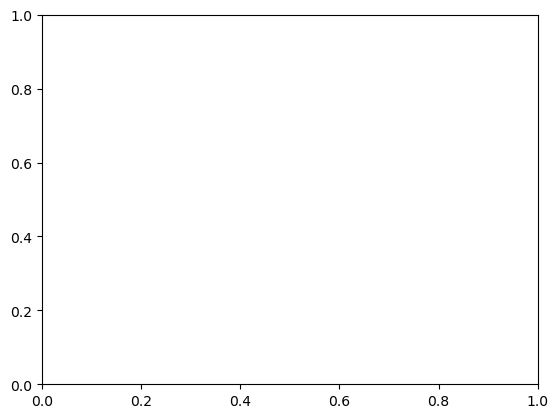

In [11]:
plot_tree(xgb_model, num_trees=0, rankdir='LR')
plt.show()

# Show me the results!

In [ ]:
def undummify(df, prefix_sep="-"):
    cols2collapse = {
        item.split(prefix_sep)[0]: (prefix_sep in item) for item in df.columns
    }
    series_list = []
    for col, needs_to_collapse in cols2collapse.items():
        if needs_to_collapse:
            undummified = (
                df.filter(like=col)
                .idxmax(axis=1)
                .apply(lambda x: x.split(prefix_sep, maxsplit=1)[1])
                .rename(col)
            )
            series_list.append(undummified)
        else:
            series_list.append(df[col])
    undummified_df = pd.concat(series_list, axis=1)
    return undummified_df

In [ ]:
pd.options.display.float_format = '{:.0f}'.format

df_results = pd.DataFrame({"predicted": y_pred, "real": y_test})
df_results["diff"] = df_results.real - df_results.predicted
df_results["diff_abs"] = abs(df_results.real - df_results.predicted)
df_results["diff_abs_round"] = round(abs(df_results.real - df_results.predicted), -3)
df_results.drop(["diff", "diff_abs"], axis=1, inplace=True)
df_results = df_results.merge(undummify(X_test), left_index=True, right_index=True).head(2000)
df_results.head(20)

In [ ]:
# worst
df_results.sort_values(by='diff_abs_round', ascending=False).head(20)

In [ ]:
# best
df_results.sort_values(by='diff_abs_round', ascending=True).head(30)

In [ ]:
df_results.real[df_results.diff_abs_round <= 20000].count()

In [ ]:
df_results.real.count()